# Reinforcement Learning: Deep Q-Learning

This notebook provides some code to implement a CNN-based deep Q-Learning (https://arxiv.org/abs/1312.5602) on a custom "visual" gridworld environment.
### *WARNING 1*: this is not "good" code, it is just for demonstration purpose. You can do better! 
The advice is to build a more complex class with many methods (e.g., integrate replay buffers and target networks, training function, save/restore functions, predict and so on) to make the main code simpler and much more readable. This requires a (slightly) deeper knowledge of TensorFlow1.x.
### *WARNING 2*: this "gridworld" environment is not part of Gym.
This is a simple demonstration environment and was not integrated in Gym. Very cool visual-input environment are available in the `Atari` section of Gym (https://gym.openai.com/envs/#atari), which have become standard benchmarks in the RL community.

In [2]:
import gym
import numpy as np
import random
import tensorflow as tf
if type(tf.contrib) != type(tf): tf.contrib._warning = None
import tensorflow.contrib.slim as slim

import scipy.misc
import matplotlib.pyplot as plt
import os
%matplotlib inline

Gridworld is the visual version of Frozen Lake. It is a custom environment that can be initialized with custom size, number of holes and goals. Reward is +10 if the agent (blue square) moves on a goal (green square), -10 if it moves onto a hole (red square).

The state that the agent is trained with is the rendered image of the environment (84x84x3 pixels), that requires a CNN as network.

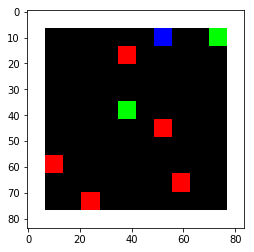

In [3]:
from gridworld import gameEnv
env = gameEnv(partial=False, size=10, nHoles=5, nGoals=2)
# env = gameEnv(size=5, nHoles=0)

In [4]:
class Qnetwork():
    def __init__(self, h_size):
        # Input definition: placeholder as image (batch_size x 84 x 84 x 3)
        self.scalarInput = tf.placeholder(shape=[None, 84*84*3], dtype=tf.float32)
        self.imageIn = tf.reshape(self.scalarInput, shape=[-1, 84, 84, 3])
        
        # Convolutions: 4 layers. Default ReLU activation. Consider using dropout/max pooling
        self.conv1 = slim.conv2d(inputs=self.imageIn, num_outputs=32, kernel_size=[8,8], stride=[4,4], \
                                padding='VALID', biases_initializer=None)
        self.conv2 = slim.conv2d(inputs=self.conv1, num_outputs=64, kernel_size=[4,4], stride=[2,2], \
                                padding='VALID', biases_initializer=None)
        self.conv3 = slim.conv2d(inputs=self.conv2, num_outputs=64, kernel_size=[3,3], stride=[1,1], \
                                padding='VALID', biases_initializer=None)
        self.conv4 = slim.conv2d(inputs=self.conv3, num_outputs=h_size, kernel_size=[7,7], stride=[1,1], \
                                padding='VALID', biases_initializer=None)
        
        # Split Value and Advantage estimation: two different Fully Connected layers.
        self.streamAC, self.streamVC = tf.split(self.conv4, 2, 3)
        self.streamA = slim.flatten(self.streamAC)
        self.streamV = slim.flatten(self.streamVC)
        xavier_init = tf.contrib.layers.xavier_initializer()
        # Definition of Weights
        self.AW = tf.Variable(xavier_init([h_size//2, env.actions]))
        self.VW = tf.Variable(xavier_init([h_size//2, 1]))
        self.Advantage = tf.matmul(self.streamA, self.AW)
        self.Value = tf.matmul(self.streamV, self.VW)
        
        # Estimate Q = V + A. Mean(A) is used as a baseline to reduce variance.
        self.Qout = self.Value + tf.subtract(self.Advantage, tf.reduce_mean(self.Advantage, axis=1, keep_dims=True))
        self.predict = tf.argmax(self.Qout, 1)
        
        # Obtain loss as sum of squares difference between target and prediction Q values.
        self.targetQ = tf.placeholder(shape=[None], dtype=tf.float32)
        self.actions = tf.placeholder(shape=[None], dtype=tf.int32)
        self.actions_onehot = tf.one_hot(self.actions, env.actions, dtype=tf.float32)
        
        self.Q = tf.reduce_sum(tf.multiply(self.Qout, self.actions_onehot), axis=1)
        
        self.td_error = self.targetQ - self.Q
        self.loss = tf.reduce_mean(tf.square(self.td_error))
        self.trainer = tf.train.AdamOptimizer(learning_rate=0.0001)
        self.updateModel = self.trainer.minimize(self.loss)

## Experience Buffer

In [5]:
class experience_buffer():
    def __init__(self, buffer_size=50000):
        self.buffer = []
        self.buffer_size = buffer_size
        
    def add(self, experience):
        if len(self.buffer) + len(experience) >= self.buffer_size:
            self.buffer[0:(len(experience) + len(self.buffer)) - self.buffer_size] = []
        self.buffer.extend(experience)
        
    def sample(self, size):
        return np.reshape(np.array(random.sample(self.buffer, size)), [size, 5])

In [6]:
# Flattens image tensor (to feed it to the net)
def processState(states):
    return np.reshape(states, [84*84*3])

In [7]:
# Update the target network variables graph (similar to Polyak averaging)
# tf.trainable_variables() = [main_net_vars, target_net_vars]
# update assigns target_net_vars = tau*main_net_vars + (1-tau)*target_net_vars
def updateTargetGraph(tfVars, tau):
    total_vars = len(tfVars)
    op_holder = []
    for idx, var in enumerate(tfVars[:total_vars//2]):
        op_holder.append(tfVars[idx + total_vars//2].assign((var.value()*tau) + ((1-tau)*tfVars[idx + total_vars//2].value())))
    return op_holder

# Run session to update.
def updateTarget(op_holder, sess):
    for op in op_holder:
        sess.run(op)

In [8]:
batch_size = 32
update_freq = 4
y = .99
startE = 1
endE = 0.1
annealing_steps = 10000.
num_episodes = 10000
pre_train_steps = 10000
max_epLength = 50
load_model = False
path = "./dqn"
h_size = 512
tau = 0.001

## Training the CNN

Once the model of the network has been defined, together with the replay buffer and all the hyperparameters needed, the training process can start. A `main` network and a `target` network must be defined, an instance of the buffer class must be declared.

In [20]:
tf.reset_default_graph()

# Define 2 networks: main (learning) and target network (kept fixed, updated every N episodes.)
mainQN = Qnetwork(h_size)
targetQN = Qnetwork(h_size)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [11]:
trainables = tf.trainable_variables()

targetOpts = updateTargetGraph(trainables, tau)

# Experience Replay Buffer
myBuffer = experience_buffer()

# Exploration rate
e = startE
stepDrop = (startE - endE)/annealing_steps

jList = []
rList = []
total_steps = 0

if not os.path.exists(path):
    os.makedirs(path)

with tf.Session() as sess:
    sess.run(init)
    if load_model:
        print("Loading model...")
        save_path = saver.restore(sess, path + "/model.ckpt")
#         ckpt = tf.train.get_checkpoint_state(path)
#         saver.restore(sess, ckpt.model_checkpoint_path)
    
    for i in range(num_episodes):
        episodeBuffer = experience_buffer()
        s = env.reset()
        s = processState(s)
        d = False
        rAll = 0
        j = 0
        
        while j < max_epLength:
            j += 1
            # First pre_train_steps actions are chosen randomly (else, are predicted by the net)
            if np.random.rand(1) < e or total_steps < pre_train_steps:
                a = np.random.randint(0,4)
            else:
                a = sess.run(mainQN.predict, feed_dict={mainQN.scalarInput:[s]})[0]
                
            s1, r, d = env.step(a)
            s1 = processState(s1)
            total_steps += 1
            episodeBuffer.add(np.reshape(np.array([s, a, r, s1, d]), [1, 5]))
            
            # Regular training
            if total_steps > pre_train_steps:
                if e > endE:
                    e -= stepDrop
                if total_steps % (update_freq) == 0:
                    # Sample batch from Experience Replay Buffer
                    trainBatch = myBuffer.sample(batch_size)
                    
                    # Feed experience replay batch to predict Q (only new states.)
                    Q_ep = sess.run(targetQN.Qout, feed_dict={targetQN.scalarInput: np.vstack(trainBatch[:, 3])})
                    
                    # Needed because target y = r if episode ends (i.e., done=True).
                    end_multiplier = -(trainBatch[:, 4] - 1)
                    targetQ = trainBatch[:, 2] + (y*np.amax(Q_ep, axis=1) * end_multiplier)
                    
                    # update main network towards Double Q-Learning value target.
                    _ = sess.run(mainQN.updateModel, feed_dict={mainQN.scalarInput: np.vstack(trainBatch[:, 0]), \
                                                                mainQN.targetQ: targetQ, mainQN.actions: trainBatch[:, 1]})
                    updateTarget(targetOpts, sess)
                    
            rAll += r
            s = s1
             
            if d:
                break
                
        myBuffer.add(episodeBuffer.buffer)
        jList.append(j)
        rList.append(rAll)
        
        if i % 2000 == 0:
            saver.save(sess, path+"/model2-"+str(i)+".ckpt")
            print("Model saved")
        if len(rList) % 10 == 0:
            print(i, total_steps, np.mean(rList[-10:]), e)
    saver.save(sess, path + "/model-" + str(i) + ".ckpt")
print("Percent of successful episodes: " + str(sum(rList)/num_episodes))

Model saved
9 500 -60.0 1
19 1000 -59.0 1
29 1500 -60.0 1
39 2000 -52.0 1
49 2500 -55.0 1
59 3000 -62.0 1
69 3500 -64.0 1
79 4000 -52.0 1
89 4500 -59.0 1
99 5000 -69.0 1
109 5500 -54.0 1
119 6000 -59.0 1
129 6500 -58.0 1
139 7000 -57.0 1
149 7500 -59.0 1
159 8000 -54.0 1
169 8500 -54.0 1
179 9000 -64.0 1
189 9500 -64.0 1
199 10000 -55.0 1
209 10500 -58.0 0.9549999999999828
219 11000 -52.0 0.9099999999999655
229 11500 -50.0 0.8649999999999483
239 12000 -66.0 0.819999999999931
249 12500 -60.0 0.7749999999999138
259 13000 -56.0 0.7299999999998965
269 13500 -50.0 0.6849999999998793
279 14000 -50.0 0.639999999999862
289 14500 -53.0 0.5949999999998448
299 15000 -56.0 0.5499999999998275
309 15500 -54.0 0.5049999999998103
319 16000 -55.0 0.4599999999998177
329 16500 -58.0 0.41499999999982823
339 17000 -51.0 0.36999999999983874
349 17500 -57.0 0.32499999999984924
359 18000 -51.0 0.27999999999985975
369 18500 -52.0 0.23499999999986562
379 19000 -49.0 0.18999999999986225
389 19500 -51.0 0.1449999

2379 119000 3.0 0.09999999999985551
2389 119500 5.0 0.09999999999985551
2399 120000 13.0 0.09999999999985551
2409 120500 8.0 0.09999999999985551
2419 121000 24.0 0.09999999999985551
2429 121500 2.0 0.09999999999985551
2439 122000 16.0 0.09999999999985551
2449 122500 3.0 0.09999999999985551
2459 123000 13.0 0.09999999999985551
2469 123500 20.0 0.09999999999985551
2479 124000 2.0 0.09999999999985551
2489 124500 32.0 0.09999999999985551
2499 125000 8.0 0.09999999999985551
2509 125500 5.0 0.09999999999985551
2519 126000 -3.0 0.09999999999985551
2529 126500 18.0 0.09999999999985551
2539 127000 13.0 0.09999999999985551
2549 127500 -1.0 0.09999999999985551
2559 128000 -2.0 0.09999999999985551
2569 128500 9.0 0.09999999999985551
2579 129000 13.0 0.09999999999985551
2589 129500 19.0 0.09999999999985551
2599 130000 6.0 0.09999999999985551
2609 130500 10.0 0.09999999999985551
2619 131000 -9.0 0.09999999999985551
2629 131500 16.0 0.09999999999985551
2639 132000 11.0 0.09999999999985551
2649 132500

4619 231000 4.0 0.09999999999985551
4629 231500 19.0 0.09999999999985551
4639 232000 10.0 0.09999999999985551
4649 232500 16.0 0.09999999999985551
4659 233000 0.0 0.09999999999985551
4669 233500 4.0 0.09999999999985551
4679 234000 22.0 0.09999999999985551
4689 234500 18.0 0.09999999999985551
4699 235000 19.0 0.09999999999985551
4709 235500 16.0 0.09999999999985551
4719 236000 20.0 0.09999999999985551
4729 236500 20.0 0.09999999999985551
4739 237000 -1.0 0.09999999999985551
4749 237500 7.0 0.09999999999985551
4759 238000 7.0 0.09999999999985551
4769 238500 1.0 0.09999999999985551
4779 239000 -5.0 0.09999999999985551
4789 239500 10.0 0.09999999999985551
4799 240000 -13.0 0.09999999999985551
4809 240500 8.0 0.09999999999985551
4819 241000 4.0 0.09999999999985551
4829 241500 4.0 0.09999999999985551
4839 242000 17.0 0.09999999999985551
4849 242500 6.0 0.09999999999985551
4859 243000 12.0 0.09999999999985551
4869 243500 8.0 0.09999999999985551
4879 244000 -10.0 0.09999999999985551
4889 24450

6859 343000 -7.0 0.09999999999985551
6869 343500 -8.0 0.09999999999985551
6879 344000 7.0 0.09999999999985551
6889 344500 10.0 0.09999999999985551
6899 345000 16.0 0.09999999999985551
6909 345500 7.0 0.09999999999985551
6919 346000 16.0 0.09999999999985551
6929 346500 -10.0 0.09999999999985551
6939 347000 -10.0 0.09999999999985551
6949 347500 17.0 0.09999999999985551
6959 348000 -4.0 0.09999999999985551
6969 348500 3.0 0.09999999999985551
6979 349000 15.0 0.09999999999985551
6989 349500 -14.0 0.09999999999985551
6999 350000 -3.0 0.09999999999985551
7009 350500 2.0 0.09999999999985551
7019 351000 -2.0 0.09999999999985551
7029 351500 -13.0 0.09999999999985551
7039 352000 3.0 0.09999999999985551
7049 352500 -4.0 0.09999999999985551
7059 353000 4.0 0.09999999999985551
7069 353500 7.0 0.09999999999985551
7079 354000 -2.0 0.09999999999985551
7089 354500 12.0 0.09999999999985551
7099 355000 -14.0 0.09999999999985551
7109 355500 -1.0 0.09999999999985551
7119 356000 -4.0 0.09999999999985551
712

9089 454500 17.0 0.09999999999985551
9099 455000 -8.0 0.09999999999985551
9109 455500 4.0 0.09999999999985551
9119 456000 7.0 0.09999999999985551
9129 456500 -16.0 0.09999999999985551
9139 457000 0.0 0.09999999999985551
9149 457500 17.0 0.09999999999985551
9159 458000 -14.0 0.09999999999985551
9169 458500 2.0 0.09999999999985551
9179 459000 -16.0 0.09999999999985551
9189 459500 -10.0 0.09999999999985551
9199 460000 15.0 0.09999999999985551
9209 460500 3.0 0.09999999999985551
9219 461000 -13.0 0.09999999999985551
9229 461500 11.0 0.09999999999985551
9239 462000 -6.0 0.09999999999985551
9249 462500 19.0 0.09999999999985551
9259 463000 -9.0 0.09999999999985551
9269 463500 -3.0 0.09999999999985551
9279 464000 -4.0 0.09999999999985551
9289 464500 0.0 0.09999999999985551
9299 465000 -9.0 0.09999999999985551
9309 465500 -6.0 0.09999999999985551
9319 466000 0.0 0.09999999999985551
9329 466500 -2.0 0.09999999999985551
9339 467000 -1.0 0.09999999999985551
9349 467500 -10.0 0.09999999999985551
93

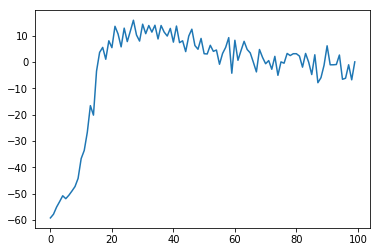

In [12]:
rMat = np.resize(np.array(rList),[len(rList)//100,100])
rMean = np.average(rMat,1)
plt.plot(rMean)

50 0 -1.0 False


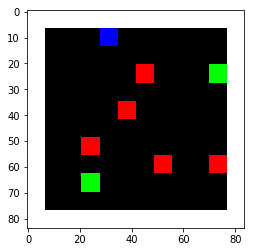

In [23]:
from IPython.display import clear_output
import time

jList = []
rList = []
total_steps = 0
e = 1

# if not os.path.exists(path):
#     os.makedirs(path)
# IMAGES = []
with tf.Session() as sess:
    sess.run(init)
#     if True:
#         print("Loading model...")
#         save_path = saver.restore(sess, path + "/model-8000.ckpt")
    
    for i in range(1):
#         episodeBuffer = experience_buffer()
        time.sleep(1)
        s = env.reset()
        plt.imshow(s)
        plt.show()
        s = processState(s)
        d = False
        rAll = 0
        j = 0
        
        while j < max_epLength:
            j += 1
            # First pre_train_steps actions are chosen randomly (else, are predicted by the net)
            if np.random.rand(1) < e:# or total_steps < pre_train_steps:
                a = np.random.randint(0,4)
            else:
                a = sess.run(mainQN.predict, feed_dict={mainQN.scalarInput:[s]})[0]
            
            s1, r, d = env.step(a)
            time.sleep(.25)
            clear_output()
#             clear_output()
            print(j, a, r, d)
            
            plt.imshow(s1)
            
            plt.savefig('images/im-' + str(j) + '.png', bbox_inches='tight')
            plt.show()
            s1 = processState(s1)
            total_steps += 1
#             episodeBuffer.add(np.reshape(np.array([s, a, r, s1, d]), [1, 5]))

            rAll += r
            s = s1
             
            if d:
                break
                
#         myBuffer.add(episodeBuffer.buffer)
        jList.append(j)
        rList.append(rAll)
        
#         if i % 1000 == 0:
#             saver.save(sess, path+"/model       -"+str(i)+".ckpt")
#             print("Model saved")
#         if len(rList) % 10 == 0:
#             print(total_steps, np.mean(rList[-10:]), e)
#     saver.save(sess, path + "/model-" + str(i) + ".ckpt")
# print("Percent of successful episodes: " + str(num(rList)/num_episodes))